In [58]:
import siconos.numerics as sn
import scipy.linalg as linalg
import numpy as np
import siconos.kernel as sk
from numpy import eye, empty, float64, zeros, transpose, array
from siconos.kernel import FirstOrderLinearTIDS, FirstOrderType2R, FirstOrderLinearTIR, EqualityConditionNSL, RelayNSL,\
                           ComplementarityConditionNSL, NonSmoothDynamicalSystem, Interaction, \
                           EulerMoreauOSI, MoreauJeanOSI, LCP, TimeDiscretisation, TimeStepping 
import siconos.numerics as sn


import ipympl
import matplotlib.pyplot as plt
%matplotlib notebook

####################################################
### READING C++ Results file ######################
# filename = 'result-evap-process-mcp-6eq-isobare.dat'
# filename = 'result-evap-process-mcp-6eq-isobare-testemptyphase.dat'
# filename = 'result-double-mix-mcp.dat'
# filename = 'result-double-mix-mcp-Cond-step-1s-FB-50iterations.dat'
# filename = 'result-double-mix-mcp-Cond-step-0_1s-FB-50iterations-Tf=260.dat'
filename = "result-double-mix-mcp-Cond-step-1s-FB-50iterations-Tf=2600.dat"
SiconosC_results = np.loadtxt(filename , dtype=float)

t      = SiconosC_results[:,0]
P     = SiconosC_results[:,1]


M1     = SiconosC_results[:,2]
V1     = SiconosC_results[:,3]
u1     = SiconosC_results[:,4]
rv1    = SiconosC_results[:,5]
rl1    = SiconosC_results[:,6]
hv1    = SiconosC_results[:,7]
hl1    = SiconosC_results[:,8]
T1     = SiconosC_results[:,9]

M2     = SiconosC_results[:,10]
V2     = SiconosC_results[:,11]
u2     = SiconosC_results[:,12]
rv2    = SiconosC_results[:,13]
rl2    = SiconosC_results[:,14]
hv2    = SiconosC_results[:,15]
hl2    = SiconosC_results[:,16]
T2     = SiconosC_results[:,17]

x1     = SiconosC_results[:,18]
ΔP1    = SiconosC_results[:,19]

x2     = SiconosC_results[:,20]
ΔP2    = SiconosC_results[:,21]

In [59]:
### Two Different laws for Saturation pressure (in function of Temperature) 

## ANTOINE LAW
# water parameters #    
A = 8.14019; # Antoine law parameter (no unit)                               
B = 1810.94; # Antoine law parameter (K)                                    
C = -28.665; # Antoine law parameter(K)  

Psat1 = lambda T: 100000*0.001*1.333*10**(A-(B/(C+T)))


## FITTED POLYNOMIAL LAW
c7=7.677448367806697e-11;
c6=-2.327974895639335e-07;
c5=2.984399245658974e-04;
c4=-2.081210501212062e-01;
c3=8.527291155079814e+01;
c2=-2.055993982138471e+04;
c1=2.704822454027627e+06;
c0=-1.499284498173245e+08;
Psat2 = lambda x: c0 + c1*x + c2*x**2 + c3*x**3 + c4*x**4 + c5*x**5 + c6*x**6 + c7*x**7

R = 461.527

<IPython.core.display.Javascript object>


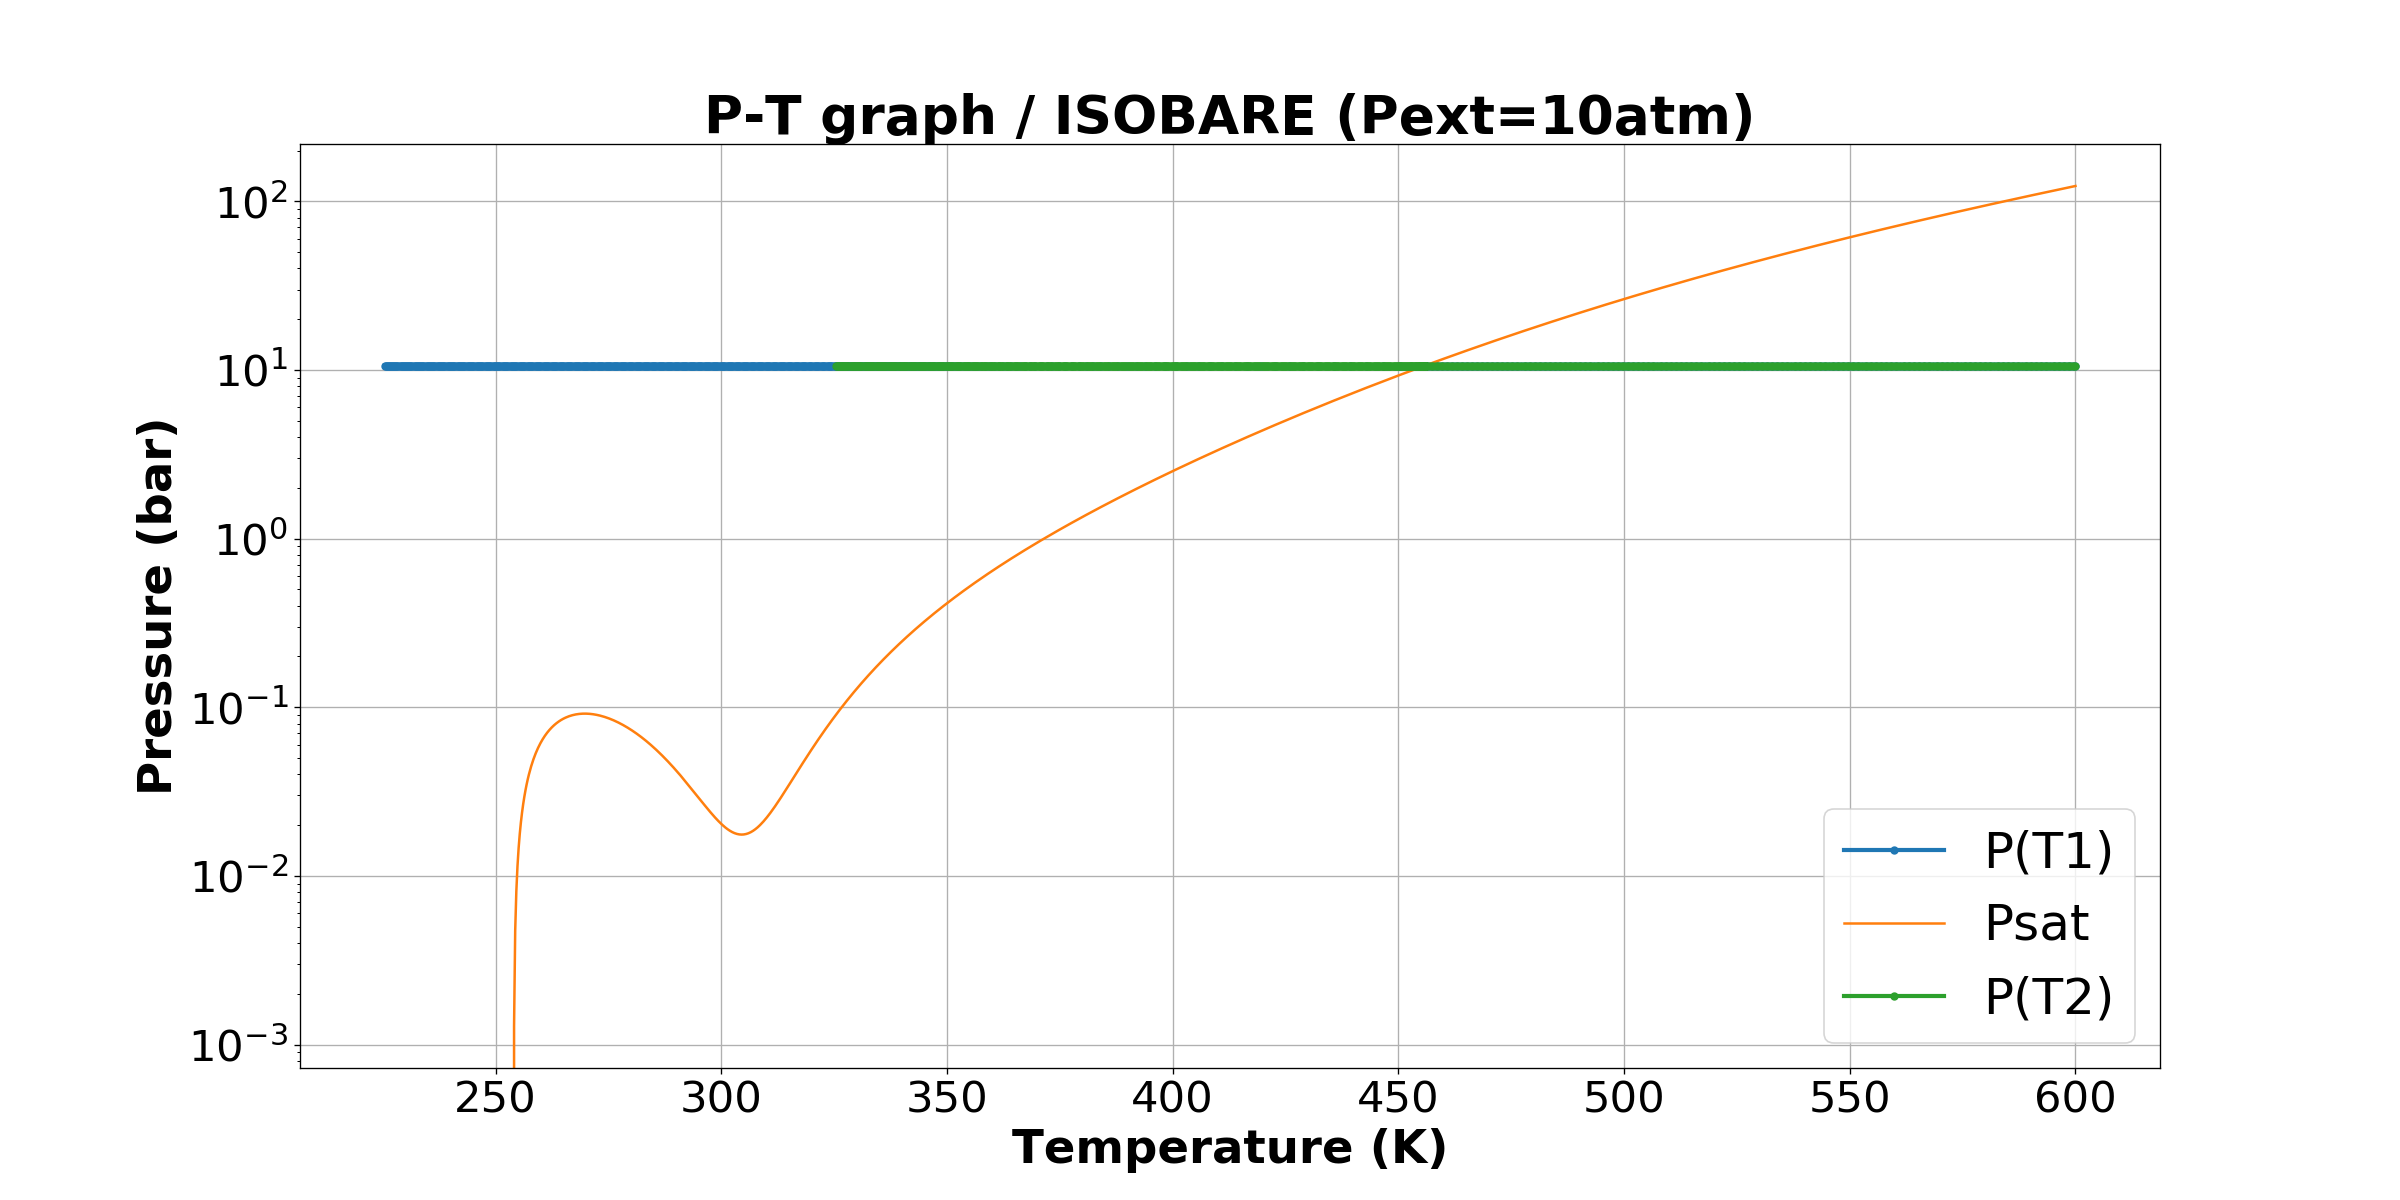

In [60]:
## P-T GRAPH MIXTURE 1
import ipympl

import matplotlib.pyplot as plt
%matplotlib notebook

plt.figure(figsize=(20,10))
plt.title('P-T graph / ISOBARE (Pext=10atm)',fontsize=32,fontweight='heavy')
# plt.title('P-T graph / ISOBARE (Pext=10atm) \n Init: T1(0)= 600.0K, M10 = 0.5kg,\n x10 = 1 \n T2(0)= 373.156.0K, M20 = 0.5kg, x20 = 0',fontsize=32,fontweight='heavy')
# plt.title('ISOCHORE (Vtot=1L) water Init: T(0)= 373.156K, M0 = 0.5kg,\n P0=Psat(T0)=1atm, rhov0 = 10kg/m^3 (Vv0= 25L)  ',fontsize=32,fontweight='heavy')
plt.plot(T1, P/100000.0, linewidth=2.5, marker='.', markersize=8, label='P(T1)')
plt.plot(T1, Psat2(T1)/100000.0, linewidth=1.5, markersize=13, label='Psat')
plt.plot(T2, P/100000.0, linewidth=2.5, marker='.', markersize=8, label='P(T2)')
# c1 = plt.plot(T, P/100000.0, label='P(T)')
# c2 = plt.plot(T, Psat(T)/100000.0, label='Psat')
plt.xlabel('Temperature (K)',fontsize=28,fontweight='bold')
plt.ylabel('Pressure (bar)',fontsize=28,fontweight='bold')
ax = plt.axes()
plt.yscale('log')
ax.tick_params(axis='both', labelsize='26')
plt.legend(fancybox=True, fontsize=30)
plt.grid()

<IPython.core.display.Javascript object>


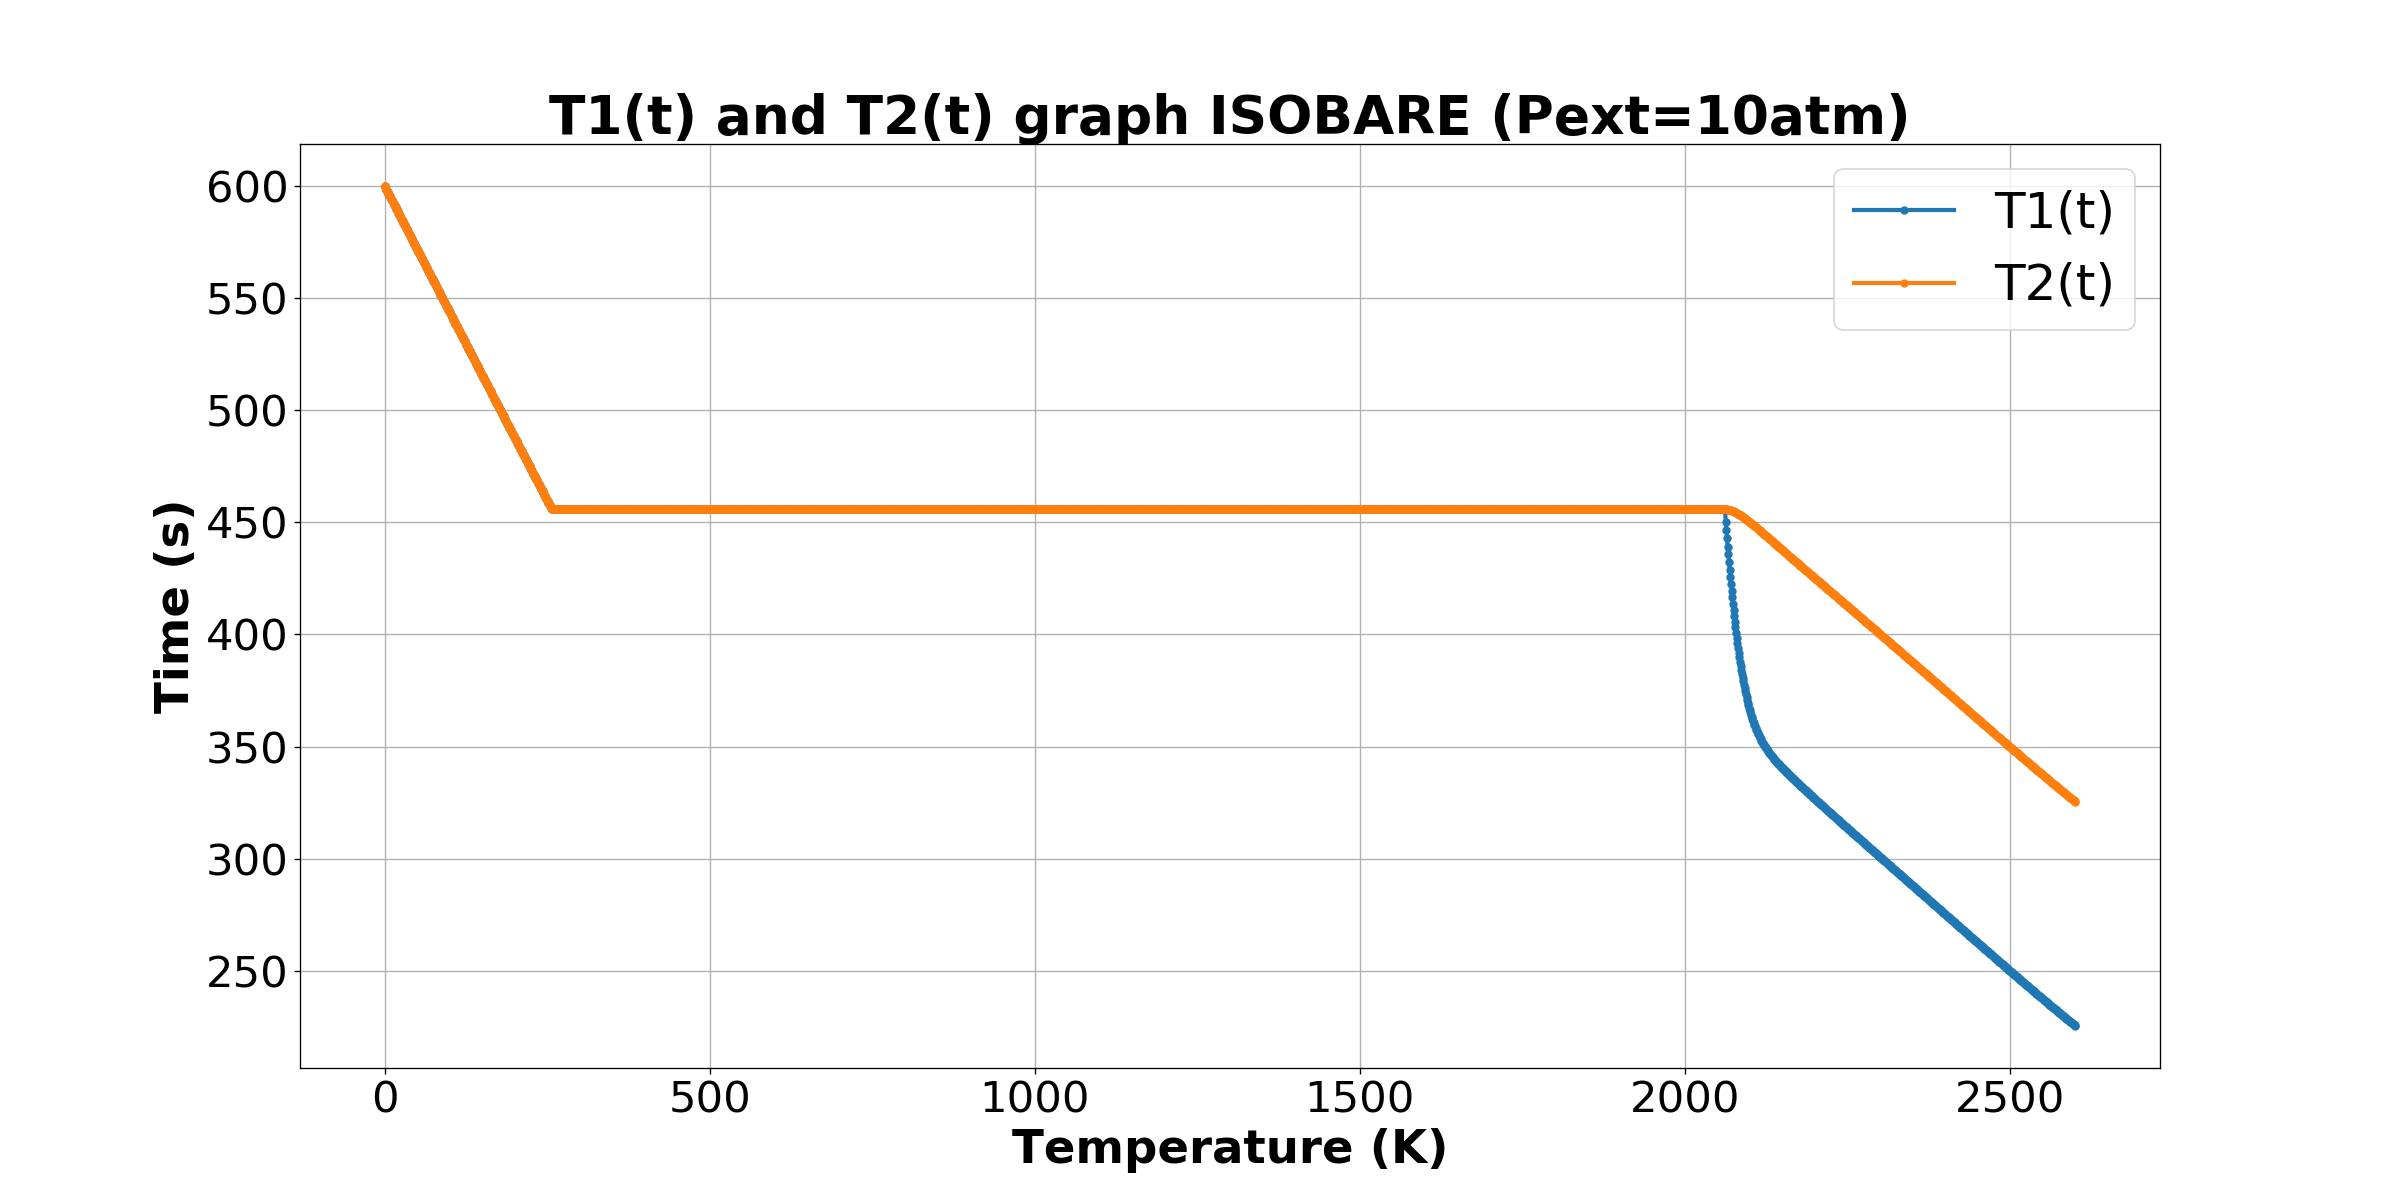

In [61]:
## Temperature evolution GRAPH MIXTURE 1
import ipympl

import matplotlib.pyplot as plt
%matplotlib notebook

plt.figure(figsize=(20,10))
# plt.title('T1(t) and T2(t) graph ISOBARE (Pext=1atm) \n Init: T1(0)= 600.0K, M10 = 0.5kg,\n x10 = 1 \n T2(0)= 373.156.0K, M20 = 0.5kg, x20 = 0',fontsize=32,fontweight='heavy')
plt.title('T1(t) and T2(t) graph ISOBARE (Pext=10atm)',fontsize=32,fontweight='heavy')
plt.plot(t,T1, linewidth=2.5, marker='.', markersize=8, label='T1(t)')
plt.plot(t,T2, linewidth=2.5, marker='.', markersize=8, label='T2(t)')
plt.xlabel('Temperature (K)',fontsize=28,fontweight='bold')
plt.ylabel('Time (s)',fontsize=28,fontweight='bold')
ax = plt.axes()
ax.tick_params(axis='both', labelsize='26')
plt.legend(fancybox=True, fontsize=30)
plt.grid()

<IPython.core.display.Javascript object>


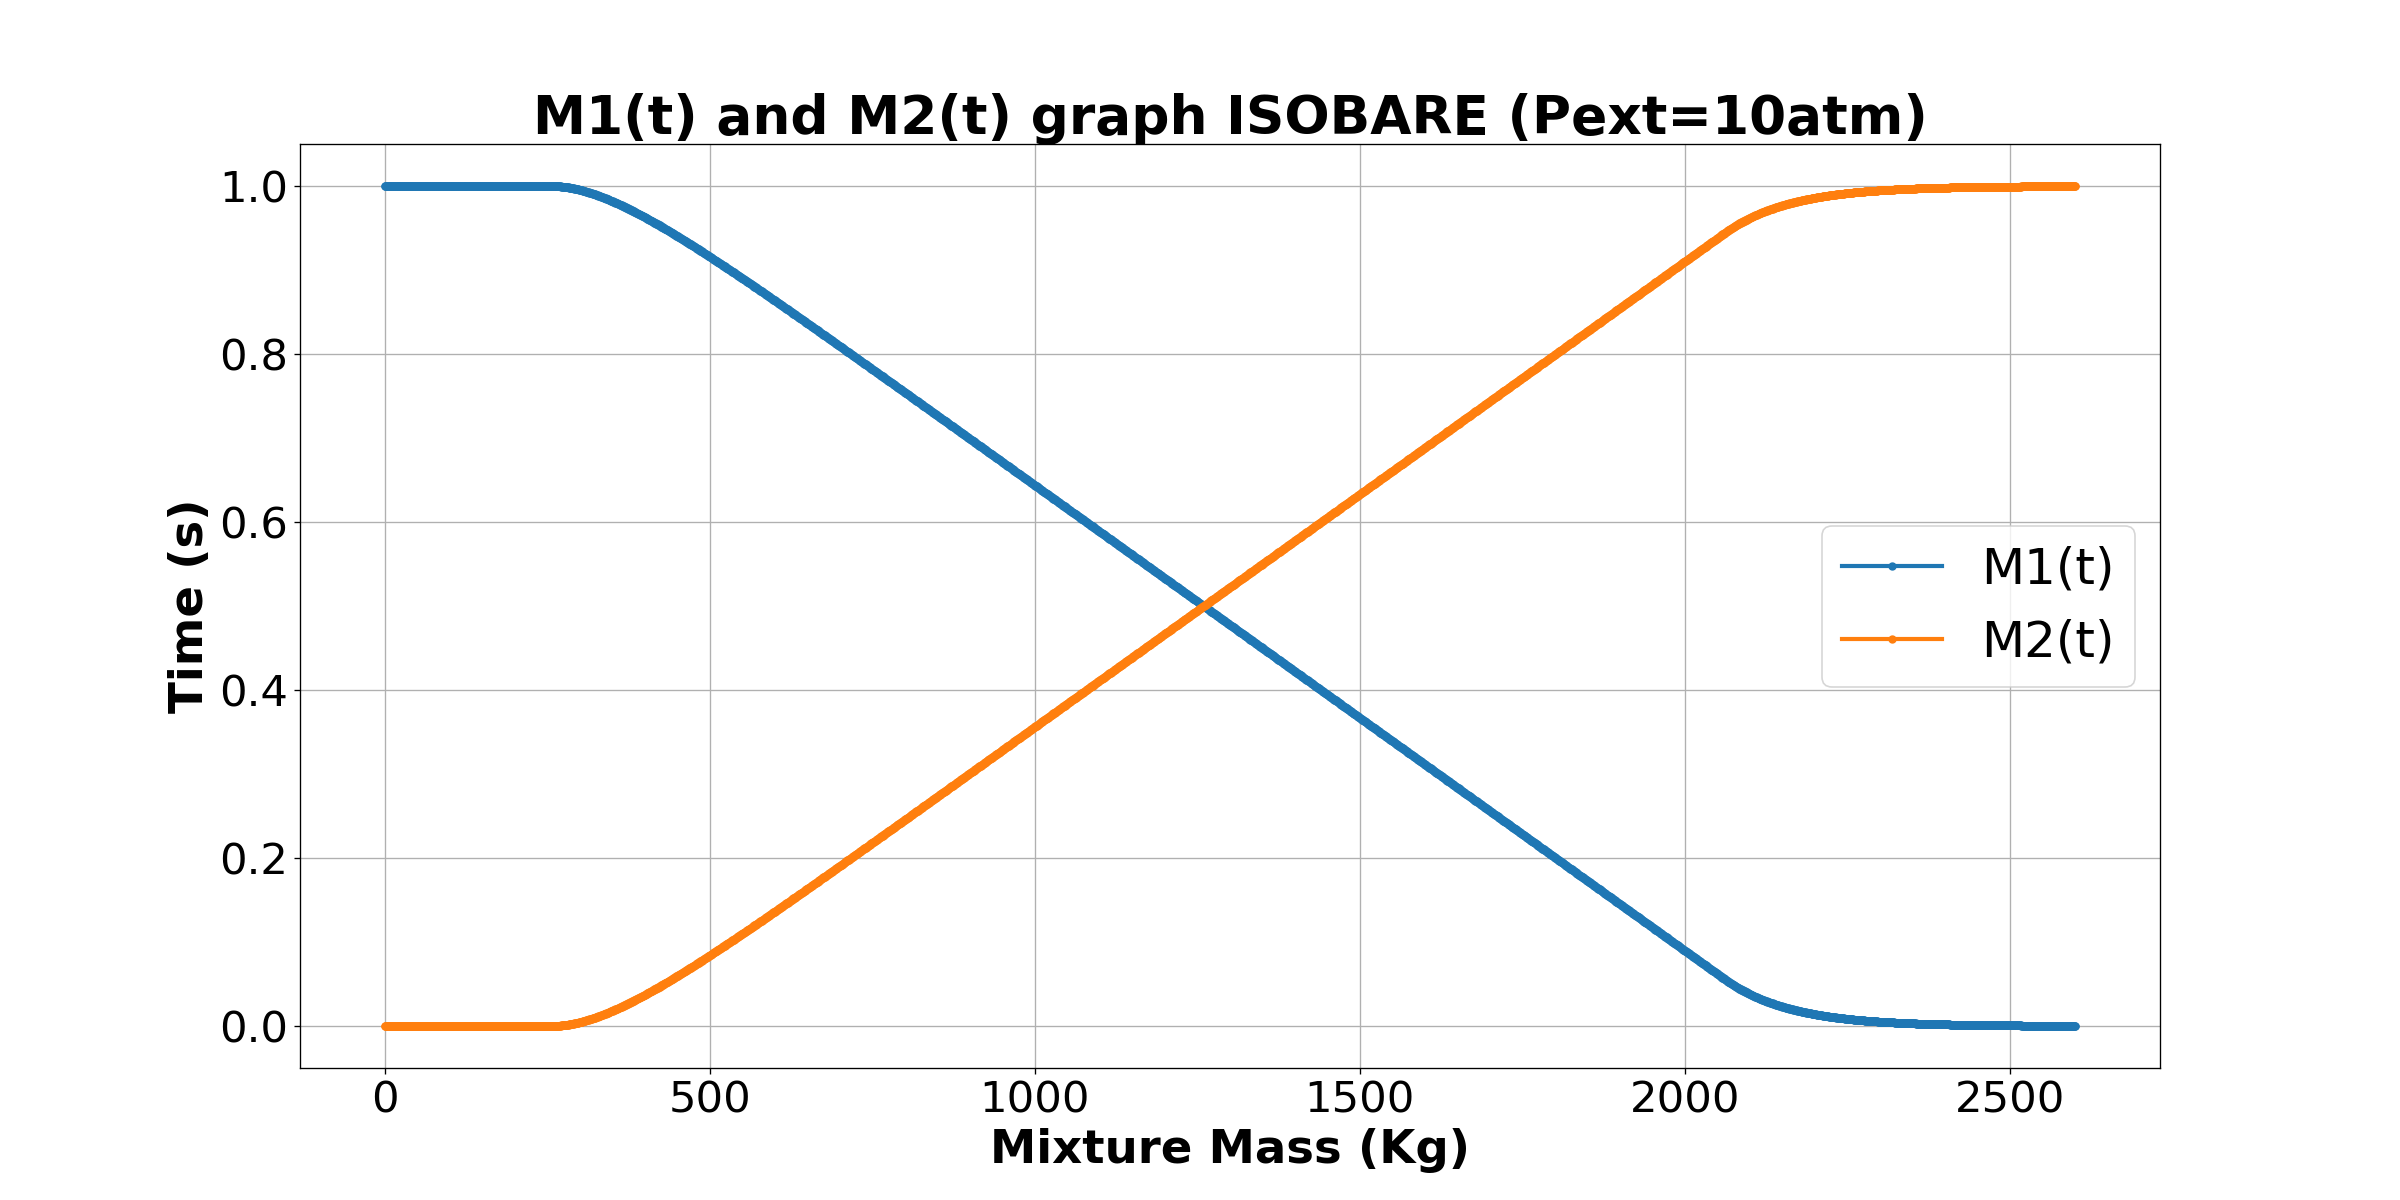

In [62]:
## Mass evolution GRAPH MIXTURE 1
import ipympl

import matplotlib.pyplot as plt
%matplotlib notebook

plt.figure(figsize=(20,10))
# plt.title('M1(t) and M2(t) graph ISOBARE (Pext=1atm) \n Init: T1(0)= 600.0K, M10 = 0.5kg,\n x10 = 1 \n T2(0)= 373.156K, M20 = 0.5kg, x20 = 0',fontsize=32,fontweight='heavy')
plt.title('M1(t) and M2(t) graph ISOBARE (Pext=10atm)',fontsize=32,fontweight='heavy')
plt.plot(t,M1, linewidth=2.5, marker='.', markersize=8, label='M1(t)')
plt.plot(t,M2, linewidth=2.5, marker='.', markersize=8, label='M2(t)')
plt.xlabel('Mixture Mass (Kg)',fontsize=28,fontweight='bold')
plt.ylabel('Time (s)',fontsize=28,fontweight='bold')
ax = plt.axes()
ax.tick_params(axis='both', labelsize='26')
plt.legend(fancybox=True, fontsize=30)
# plt.yscale('log')
plt.grid()

<IPython.core.display.Javascript object>


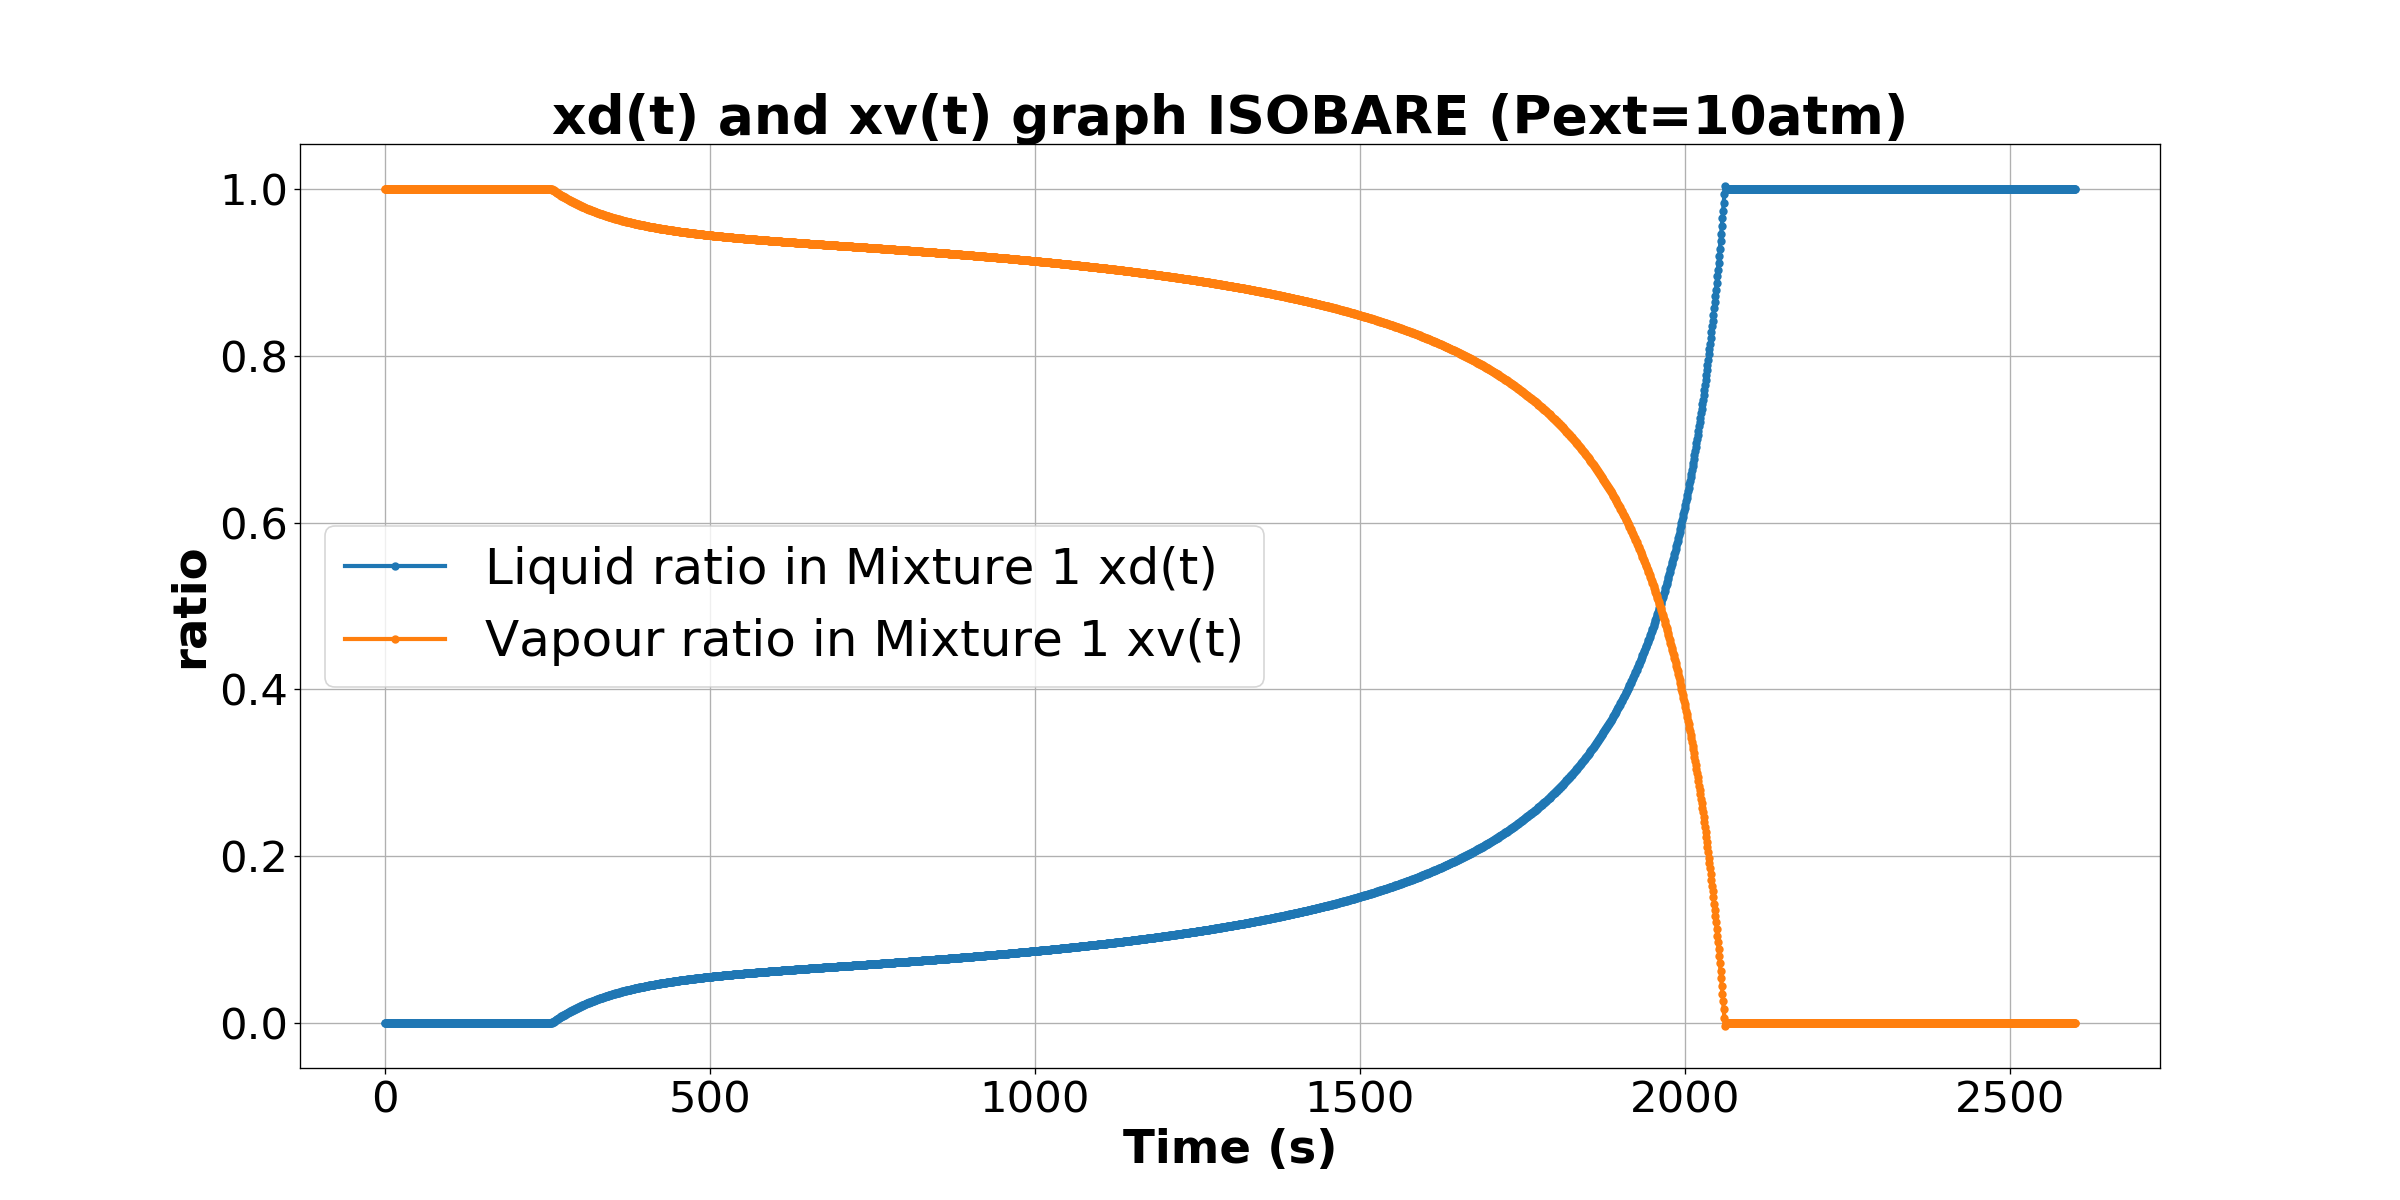

In [63]:
## Mass ratio evolution in MIXTURE 1
import ipympl

import matplotlib.pyplot as plt
%matplotlib notebook

plt.figure(figsize=(20,10))
plt.title('xd(t) and xv(t) graph ISOBARE (Pext=10atm)',fontsize=32,fontweight='heavy')
# plt.title('xd(t) and xv(t) graph ISOBARE (Pext=1atm) \n Init: T1(0)= 600.0K, M10 = 0.5kg,\n x10 = 1 \n T2(0)= 373.156K, M20 = 0.5kg, x20 = 0',fontsize=32,fontweight='heavy')
plt.plot(t,1.0-x1, linewidth=2.5, marker='.', markersize=8, label='Liquid ratio in Mixture 1 xd(t)')
plt.plot(t,x1, linewidth=2.5, marker='.', markersize=8, label='Vapour ratio in Mixture 1 xv(t)')
plt.xlabel('Time (s)',fontsize=28,fontweight='bold')
plt.ylabel('ratio',fontsize=28,fontweight='bold')
ax = plt.axes()
ax.tick_params(axis='both', labelsize='26')
plt.legend(fancybox=True, fontsize=30)
# plt.yscale('log')
plt.grid()

<IPython.core.display.Javascript object>


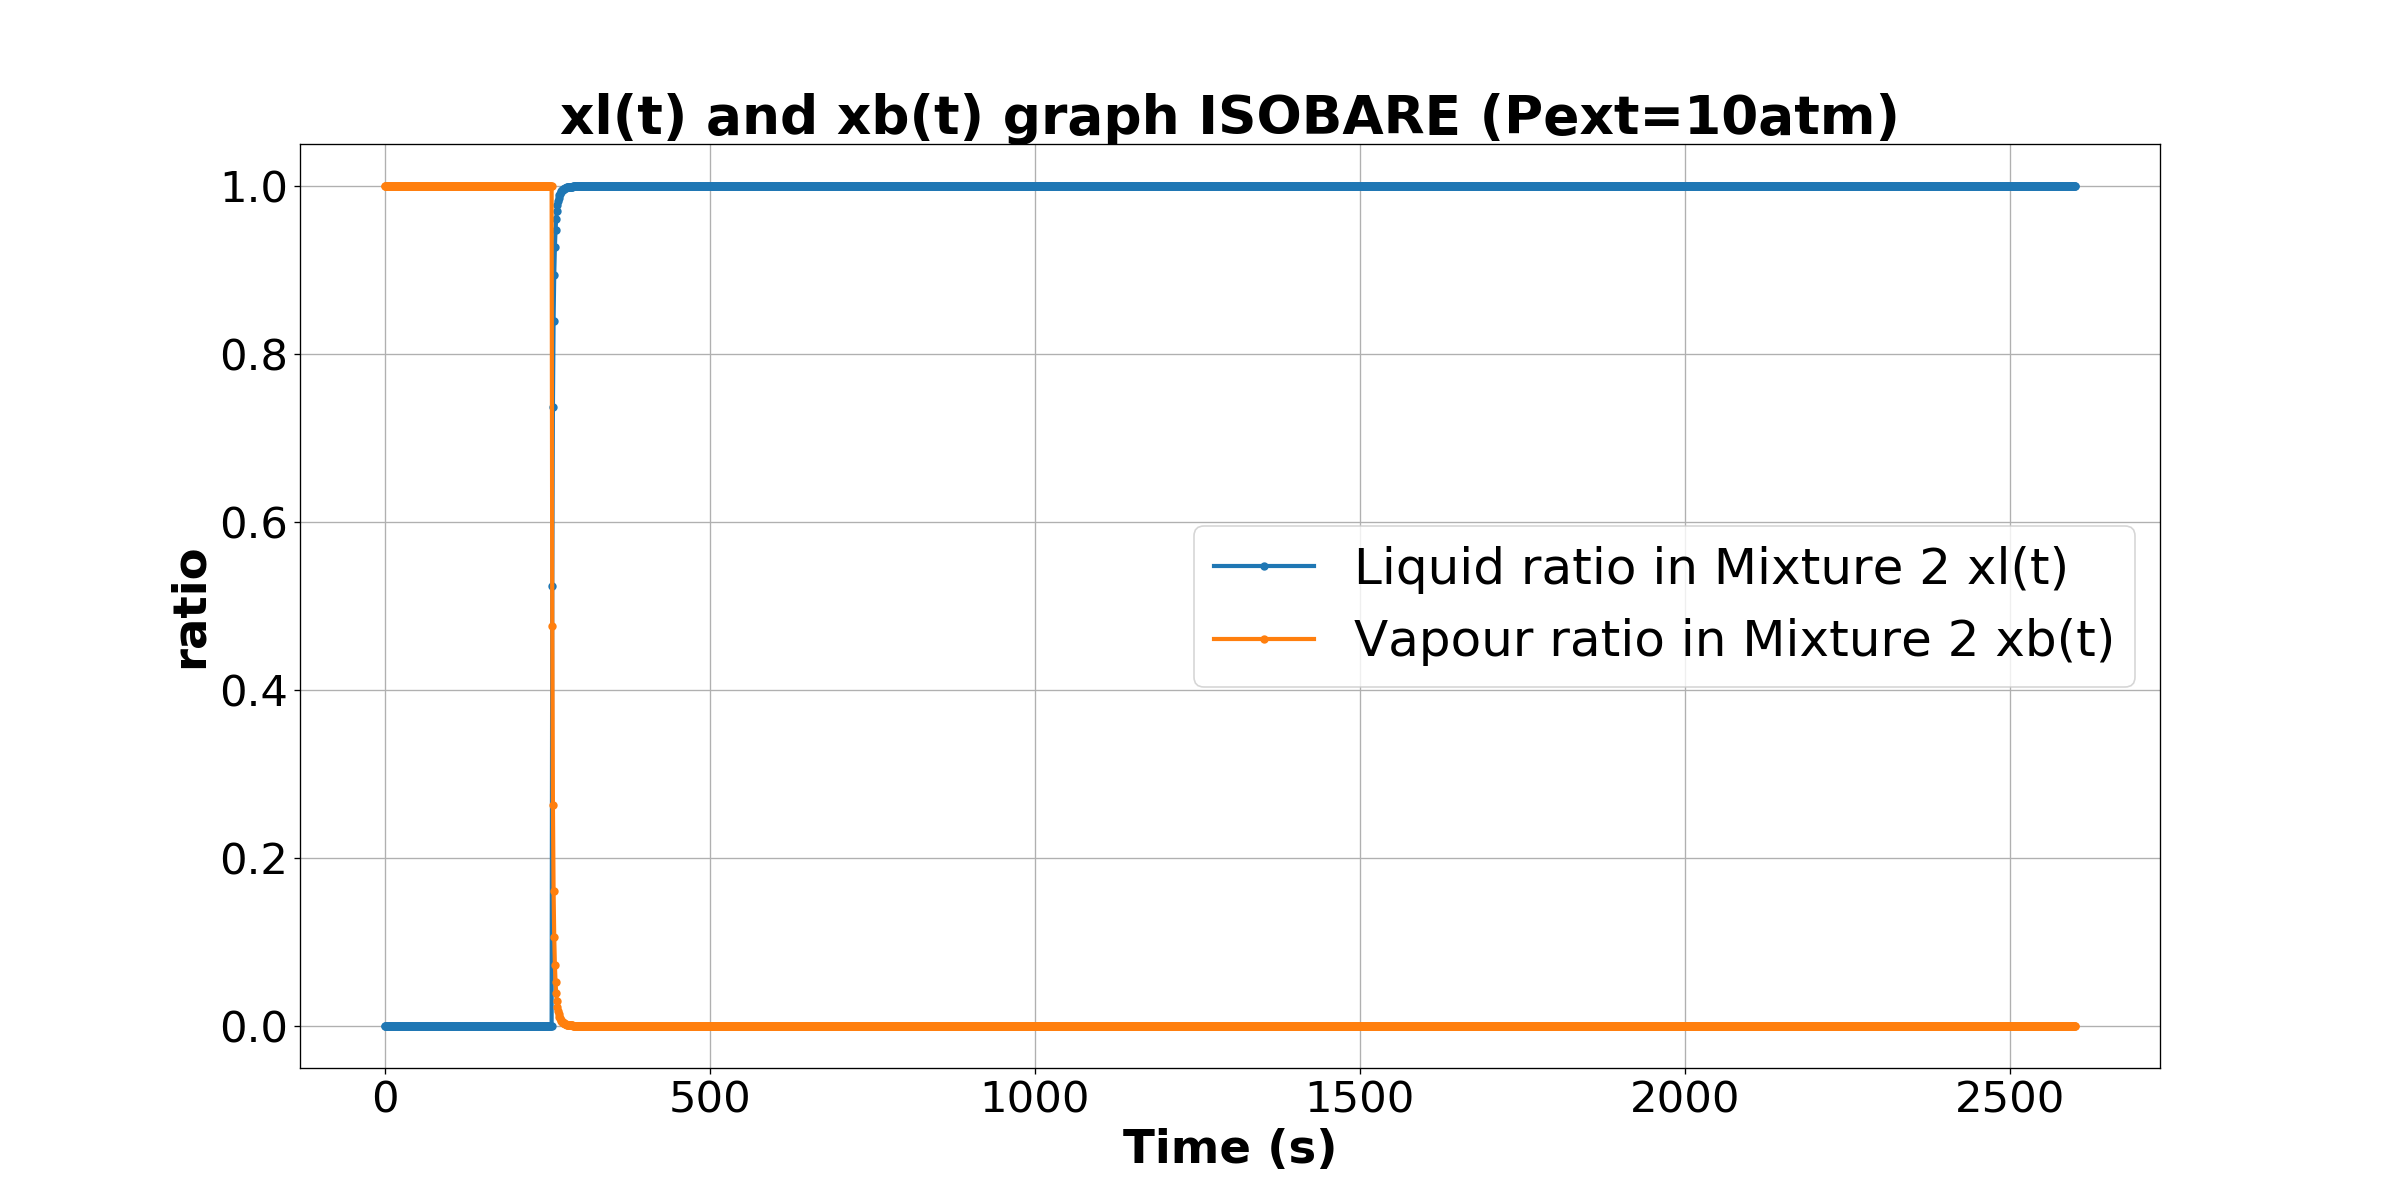

In [64]:
## Mass ratio evolution in MIXTURE 2
import ipympl

import matplotlib.pyplot as plt
%matplotlib notebook

plt.figure(figsize=(20,10))
plt.title('xl(t) and xb(t) graph ISOBARE (Pext=10atm)',fontsize=32,fontweight='heavy')
# plt.title('xl(t) and xb(t) graph ISOBARE (Pext=1atm) \n Init: T1(0)= 600.0K, M10 = 0.5kg, x10 = 1 \n T2(0)= 373.156K, M20 = 0.5kg, x20 = 0',fontsize=32,fontweight='heavy')
plt.plot(t,1.0-x2, linewidth=2.5, marker='.', markersize=8, label='Liquid ratio in Mixture 2 xl(t)')
plt.plot(t,x2, linewidth=2.5, marker='.', markersize=8, label='Vapour ratio in Mixture 2 xb(t)')
plt.xlabel('Time (s)',fontsize=28,fontweight='bold')
plt.ylabel('ratio',fontsize=28,fontweight='bold')
ax = plt.axes()
# plt.yscale('log')
ax.tick_params(axis='both', labelsize='26')
plt.legend(fancybox=True, fontsize=30)
plt.grid()